In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from scipy import stats

%matplotlib inline
#plt.style.use('ggplot')

In [2]:
def class_contour(X,X_train,Y_train,model):
    ''' function that returns arrays of the countour of the decision boundary of class 0 '''    
    xx, yy = np.meshgrid(np.linspace(-2, 2, 100),
                        np.linspace(-2, 2, 100))
    if model == 'naive':
        clf = GaussianNB()
        clf.fit(X_train,np.array(Y_train))
        Z = clf.predict_proba(np.c_[xx.ravel(),yy.ravel()])
        Z = Z[:,1].reshape(xx.shape)
    elif model == 'dt':
        clf = DecisionTreeClassifier(random_state=0).fit(X_train,np.array(Y_train))
        Z = clf.predict_proba(np.c_[xx.ravel(),yy.ravel()])
        Z = Z[:,1].reshape(xx.shape)
    return xx,yy,Z

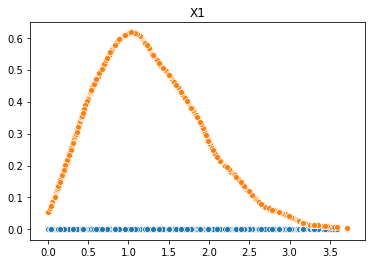

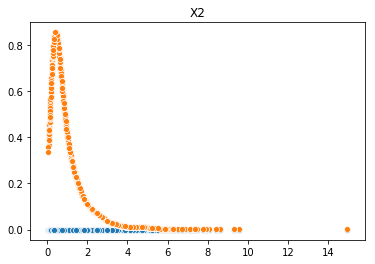

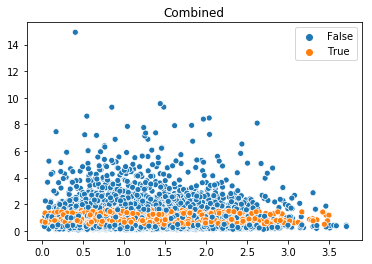

In [87]:
#Create kernel data
x1 = np.random.rayleigh(size=5000)
x2 = np.random.wald(mean=1,scale=1,size=5000)

kernelX1 = stats.gaussian_kde(x1)
kernelX2 = stats.gaussian_kde(x2)
#TODO not sure the right way to set y based on what we want to show
y = (kernelX1(x2) > .4) & (kernelX2(x2) > .2) & (kernelX1(x2) < .6) & (kernelX2(x2) < .9)

fig, ax = plt.subplots(1, 1)
ax.set_title("X1")
sns.scatterplot(x=x1,y=[0]*5000)
sns.scatterplot(x=x1,y=kernelX1(x1))
plt.show()

fig, ax = plt.subplots(1, 1)
ax.set_title("X2")
sns.scatterplot(x=x2,y=[0]*5000)
sns.scatterplot(x=x2,y=kernelX2(x2))
plt.show()

fig, ax = plt.subplots(1, 1)
ax.set_title("Combined")
sns.scatterplot(x=x1,y=x2,hue=y)
plt.show()

Gaussian Accuracy: 0.704
Gaussian Recall: 0.8189473684210526
Kernel Accuracy: 0.9784
Kernel Recall: 0.9978947368421053


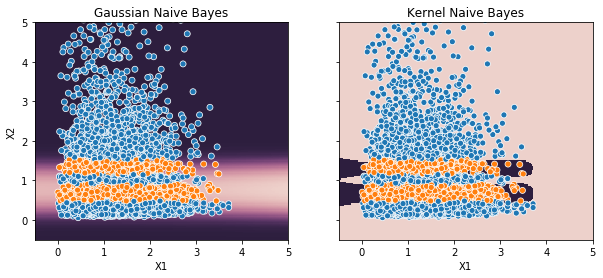

In [90]:
#Estimation
data = pd.DataFrame({"X1":x1,"X2":x2,"Y":y})
train, test = train_test_split(data, shuffle=True)

#Generate grid of data points to show prediction
xgrid = ygrid = np.linspace(-1,5,200)
grid = pd.DataFrame(np.array(np.meshgrid(xgrid,ygrid)).T.reshape(-1,2))
grid = grid.rename(index=int, columns={0: "X1", 1: "X2"})

#NB
gnb = GaussianNB()
gnb.fit(train.iloc[:,0:2],train.iloc[:,2])
grid["PredictionNB"]= gnb.predict_proba(grid)[:,0]

tn, fp, fn, tp = confusion_matrix(test["Y"],gnb.predict(test.iloc[:,0:2])).ravel()
print("Gaussian Accuracy:",((tp+tn)/(tn+fp+fn+tp)))
print("Gaussian Recall:",((tp)/(fn+tp)))

#Plotting
fig, ax = plt.subplots(1, 2,sharex='col', sharey='row')
#plt.suptitle("Classifying XOR Data", y=1,fontsize=20)
fig.set_size_inches(10, 4)
ax[0].set_ylim([-.5,5])
ax[0].set_xlim([-.5,5])
ax[1].set_ylim([-.5,5])
ax[1].set_xlim([-.5,5])

#Plot NB
ax[0].set_title("Gaussian Naive Bayes")
sns.scatterplot(x=grid["X1"],y=grid["X2"], hue=grid["PredictionNB"],s=20,linewidth=0,alpha=1,marker='s', ax=ax[0])
#xx,yy,z = class_contour(df.iloc[:,:2].values,trainX,trainY,'naive')
#ax[0].contour(xx,yy,z,[.5])
sns.scatterplot(x=x1,y=x2,hue=y, ax=ax[0])
ax[0].legend().remove()

#Kernel NB
#Prediction is the product of feature prob kernel given class 1 over class 2
kernelX1Y1 = stats.gaussian_kde(train[train["Y"]==True]["X1"].values)
kernelX1Y0 = stats.gaussian_kde(train[train["Y"]==False]["X1"].values)
kernelX2Y1 = stats.gaussian_kde(train[train["Y"]==True]["X2"].values)
kernelX2Y0 = stats.gaussian_kde(train[train["Y"]==False]["X2"].values)
priorY1 = train[train["Y"]==True]["X1"].values.size / train["X1"].values.size
priorY0 = train[train["Y"]==False]["X1"].values.size / train["X1"].values.size

predictions = ((kernelX1Y1(grid["X1"].values) * kernelX2Y1(grid["X2"].values) * priorY1)/\
                       (kernelX1Y0(grid["X1"].values) * kernelX2Y0(grid["X2"].values) * priorY0))
predictions = predictions > 1

ax[1].set_title("Kernel Naive Bayes")
sns.scatterplot(x=grid["X1"],y=grid["X2"], hue=predictions-.01,s=20,linewidth=0,alpha=1,marker='s', ax=ax[1])
sns.scatterplot(x=x1,y=x2,hue=y, ax=ax[1])
ax[1].legend().remove()

predictions = ((kernelX1Y1(test["X1"].values) * kernelX2Y1(test["X2"].values) * priorY1)/\
                       (kernelX1Y0(test["X1"].values) * kernelX2Y0(test["X2"].values) * priorY0))
predictions = predictions > 1

tn, fp, fn, tp = confusion_matrix(test["Y"],predictions).ravel()
print("Kernel Accuracy:",((tp+tn)/(tn+fp+fn+tp)))
print("Kernel Recall:",((tp)/(fn+tp)))


